In [41]:
import logging
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import model
import anomaly_detection
from utils import SignalDataset
from interface import train

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler

In [42]:
def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

In [43]:
def known_anomalies(anomalies_list):
    found = list()
    for i in range(len(anomalies_list)):
        if anomalies_list[i] == 1:
            found.append(i)
    return found
        

In [44]:
def plot(dfs, anomalies=[]):   
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]
        
    df = dfs[0]
    time = convert_date(df['timestamp'])
    anomalies_data = []
    if 'anomaly' in df.columns:
        anomalies_data = known_anomalies(df['anomaly'])

    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)

    for df in dfs:
        plt.plot(time, df['signal'])
    
    for a_f in anomalies_data:
        plt.axvline(time[a_f], color='r', alpha=0.02)

    plt.title('Dataset', size=34)
    plt.ylabel('value', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([time[0], time[-1]])
    
    plt.show()

In [45]:
#plot signal shape
temperature_data = pd.read_csv('./datasets/machine_temperature_system_failure.csv')
temperature_data['timestamp'] = pd.to_datetime(temperature_data['timestamp'])
temperature_data['timestamp'] = temperature_data['timestamp'].apply(lambda x: (x-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
temperature_data = temperature_data.rename(columns={"value": "signal"})
temperature_data['anomaly'] = 0
min_max_scaler = MinMaxScaler()
temperature_data[['signal']] = min_max_scaler.fit_transform(temperature_data[["signal"]])
temperature_data = temperature_data[:5000]
print(temperature_data.head())
print(temperature_data.info())
temperature_data.to_csv('./datasets/temperature_prepared.csv', index=False)

timestamp    signal  anomaly
0  1386018900  0.675424        0
1  1386019200  0.684525        0
2  1386019500  0.695691        0
3  1386019800  0.714638        0
4  1386020100  0.725812        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5000 non-null   int64  
 1   signal     5000 non-null   float64
 2   anomaly    5000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 117.3 KB
None


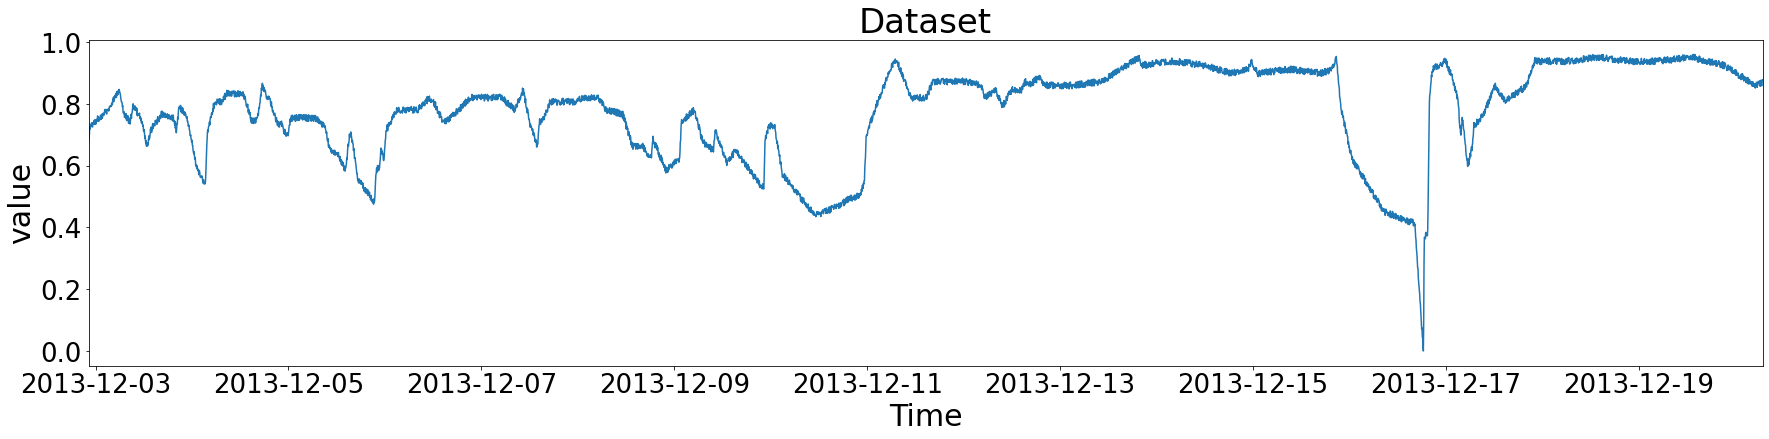

In [46]:
plot(temperature_data)

In [47]:
train_dataset = SignalDataset(path=f'./datasets/temperature_prepared.csv')

In [48]:
def critic_x_iteration(sample):
    optim_cx.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x)  # Wasserstein Loss

    # The sampled z are the anomalous points - points deviating from actual distribution of z (obtained through
    # encoding x)
    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)  # Wasserstein Loss

    alpha = torch.rand(x.shape)
    ix = Variable(alpha * x + (1 - alpha) * x_)  # Random Weighted Average
    ix.requires_grad_(True)
    v_ix = critic_x(ix)
    v_ix.mean().backward()
    gradients = ix.grad
    # Gradient Penalty Loss
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    # Critic has to maximize Cx(Valid X) - Cx(Fake X).
    # Maximizing the above is same as minimizing the negative.
    wl = critic_score_fake_x - critic_score_valid_x
    loss = wl + gp_loss
    loss.backward()
    optim_cx.step()

    return loss

In [49]:
def critic_z_iteration(sample):
    optim_cz.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)  # Wasserstein Loss

    wl = critic_score_fake_z - critic_score_valid_z

    alpha = torch.rand(z.shape)
    iz = Variable(alpha * z + (1 - alpha) * z_)  # Random Weighted Average
    iz.requires_grad_(True)
    v_iz = critic_z(iz)
    v_iz.mean().backward()
    gradients = iz.grad
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    loss = wl + gp_loss
    loss.backward()
    optim_cz.step()

    return loss


In [50]:
def encoder_iteration(sample):
    optim_enc.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x)  # Wasserstein Loss

    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_enc = mse + critic_score_valid_x - critic_score_fake_x
    loss_enc.backward(retain_graph=True)
    optim_enc.step()

    return loss_enc

In [51]:
def decoder_iteration(sample):
    optim_dec.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_dec = mse + critic_score_valid_z - critic_score_fake_z
    loss_dec.backward(retain_graph=True)
    optim_dec.step()

    return loss_dec

In [52]:
def train(n_epochs=100):
    cx_epoch_loss = list()
    cz_epoch_loss = list()
    encoder_epoch_loss = list()
    decoder_epoch_loss = list()

    for epoch in range(n_epochs):
        n_critics = 5

        cx_nc_loss = list()
        cz_nc_loss = list()

        for i in range(n_critics):
            cx_loss = list()
            cz_loss = list()

            for batch, sample in tqdm(enumerate(train_loader)):
                loss = critic_x_iteration(sample)
                cx_loss.append(loss)

                loss = critic_z_iteration(sample)
                cz_loss.append(loss)

            cx_nc_loss.append(torch.mean(torch.tensor(cx_loss)))
            cz_nc_loss.append(torch.mean(torch.tensor(cz_loss)))

        encoder_loss = list()
        decoder_loss = list()

        for batch, sample in tqdm(enumerate(train_loader)):
            enc_loss = encoder_iteration(sample)
            dec_loss = decoder_iteration(sample)
            encoder_loss.append(enc_loss)
            decoder_loss.append(dec_loss)

        cx_epoch_loss.append(torch.mean(torch.tensor(cx_nc_loss)))
        cz_epoch_loss.append(torch.mean(torch.tensor(cz_nc_loss)))
        encoder_epoch_loss.append(torch.mean(torch.tensor(encoder_loss)))
        decoder_epoch_loss.append(torch.mean(torch.tensor(decoder_loss)))
        print("epoch", epoch)
        print('critic x loss {:.3f} critic z loss {:.3f} encoder loss {:.3f} decoder loss {:.3f}\n'.format(
            cx_epoch_loss[-1], cz_epoch_loss[-1], encoder_epoch_loss[-1], decoder_epoch_loss[-1]))
        

In [53]:
def evaluate(test_loader):

    reconstructed_unroll = []

    for batch, sample in tqdm(enumerate(train_loader)):
        reconstructed_signal = decoder(encoder(sample['signal']))
        reconstructed_signal = torch.squeeze(reconstructed_signal)
        median_values, median_indices = torch.median(reconstructed_signal, 1)
        median_values_list = median_values.tolist()
        reconstructed_unroll.extend(median_values_list)
    return np.asarray(reconstructed_unroll)


In [54]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)

lr = 1e-6

signal_shape = 100
latent_space_dim = 20

encoder = model.Encoder(signal_shape)
decoder = model.Decoder(signal_shape)
critic_x = model.CriticX(signal_shape)
critic_z = model.CriticZ()

mse_loss = torch.nn.MSELoss()

optim_enc = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_dec = optim.Adam(decoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cx = optim.Adam(critic_x.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cz = optim.Adam(critic_z.parameters(), lr=lr, betas=(0.5, 0.999))

train(n_epochs = 100)

t [00:04, 15.88it/s]
4it [00:00, 19.26it/s]epoch 21
critic x loss -1.134 critic z loss 0.453 encoder loss 1.854 decoder loss 0.241

76it [00:03, 19.62it/s]
76it [00:04, 17.48it/s]
76it [00:04, 17.68it/s]
76it [00:03, 19.05it/s]
76it [00:04, 18.66it/s]
76it [00:04, 15.63it/s]
2it [00:00, 19.10it/s]epoch 22
critic x loss -1.215 critic z loss 0.448 encoder loss 1.935 decoder loss 0.244

76it [00:04, 18.49it/s]
76it [00:04, 17.81it/s]
76it [00:04, 16.92it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.08it/s]
76it [00:05, 14.58it/s]
2it [00:00, 17.75it/s]epoch 23
critic x loss -1.296 critic z loss 0.445 encoder loss 2.016 decoder loss 0.245

76it [00:04, 18.33it/s]
76it [00:04, 18.38it/s]
76it [00:04, 18.37it/s]
76it [00:04, 18.38it/s]
76it [00:04, 18.40it/s]
76it [00:05, 15.02it/s]
2it [00:00, 18.23it/s]epoch 24
critic x loss -1.377 critic z loss 0.441 encoder loss 2.097 decoder loss 0.250

76it [00:04, 18.35it/s]
76it [00:04, 18.36it/s]
76it [00:04, 18.43it/s]
76it [00:04, 17.09it/s]
76it [0

In [55]:
reconstructed_data = evaluate(train_loader)
reconstructed_data

76it [00:03, 20.53it/s]


array([0.0430781 , 0.04307995, 0.04307877, ..., 0.04333964, 0.04332798,
       0.04334388])

In [56]:
print(len(reconstructed_data))

4864


In [57]:
x_values = np.arange(start=0, stop=len(reconstructed_data), step=1)
print(len(x_values))

4864


In [58]:
signal_to_compare = temperature_data['signal'][:len(reconstructed_data)]

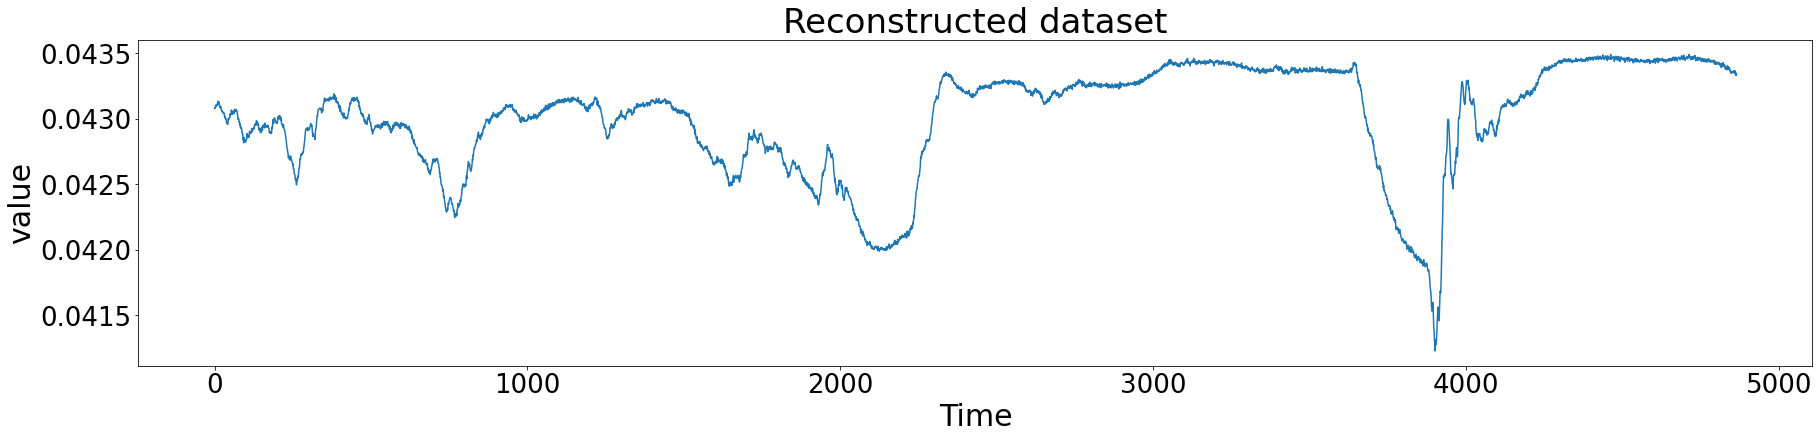

In [71]:
fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

plt.plot(x_values, reconstructed_data)

plt.title('Reconstructed dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
    
plt.show()

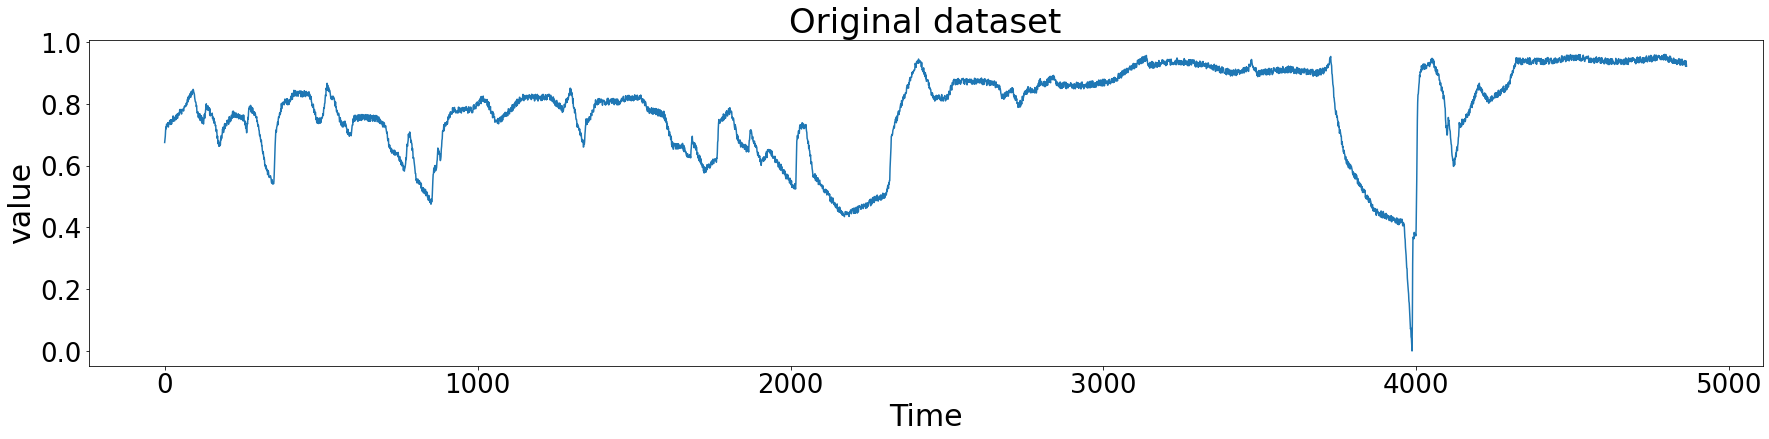

In [72]:
fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

plt.plot(x_values, signal_to_compare)

plt.title('Original dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
    
plt.show()